# Handwriting recognition with MNIST dataset - Tensorflow low-level API

This is a classic machine learning example. A possible solution using tensorflow low-level API is presented in the section 2 of course.

The MNIST dataset is a collection of 70,000 handwriting samples of the numbers 0-9. The objective is to predict which number each handwritten image represents. This is a relatively simple task, so advanced or specific neural networks for image recognition are not necessary. It is possible to achieve good results using the tensorflow low-level API without a lot of code.

In this example, each image is 28x28 grayscale pixels, and it is possible to treat each image as just a 1D array of 784 numbers. MNIST dataset conveniently is part of tensorflow library. 

In [1]:
# Import MNIST data set

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
# Prepare MNIST data: reshape images into 1D arrays of 784 pixes the label data into one-hot-encoded categorical format

num_features = 784 # data features (img shape: 28*28)

# Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Images to 1-D vector of 784 features
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from 0-255 to 0-1
x_train, x_test = x_train / 255., x_test / 255.

In [3]:
print(len(x_train), 'training samples,', len(x_test), 'testing samples')

60000 training samples, 10000 testing samples


MNIST provides 60000 samples in a training data set and 10000 samples in a testing data set. The training **images** are a tensor of shape [60,000, 784] - 60000 samples of 784 numbers that represent the images. The training **labels** are a one-dimensional tensor of 60000 labels that range from 0 to 9.

# Random sample visualization

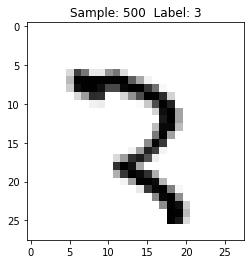

In [4]:
# function to visualize the input data - pick some random training image.

import matplotlib.pyplot as plt

def display_sample(num):
    #Print num label 
    label = y_train[num] 
    
    #Reshape the 784 values back to a 28x28 image
    image = x_train[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(500)

Damn, is that really a 3? Lol. It is hard to guess even as a human, imagine a machine! 
The images are being flattened to a 1D array of 784 (28 x 28). Each  of those 784 values will be an input node into the  neural network.

# Input data visualization

In [5]:
# Creates a np.array with the first sample of training data
images = x_train[0].reshape([1,784])

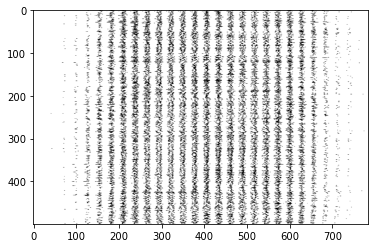

In [6]:
# Just the first 500 images
for i in range(1, 500):
    # For each step, input the sample of index i from training data to images
    images = np.concatenate((images, x_train[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

x axis is the image (784 points) and y axis is the sample. Each pixel on each row is a input of a neural network 784 neurons wide. 

# Hyperparameters

In [7]:
# Hyperparameters 
learning_rate = 0.001
training_steps = 3000
batch_size = 250
display_step = 100

# Neurons
n_hidden_1 = 784 # Number of neurons in hidden layer.
n_hidden_2 = 512

# Shuffling the data

tf.data API is used to shuffle the data and divide it into batches.

- Tensorflow Dataset function is used to wrap training features and labels. 
- It is also used to randomly shuffle the training data and batch it in smaller chunks for each iteration of training.

In [8]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

# Weights and biases

Creating variables to keep track of the weights and biases.

In [9]:
num_classes = 10 # 0 to 9

# Store layers weight & bias

# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

# Dict with weights of each neuron in each layer - hidden, output
weights = {
    'h1': tf.Variable(random_normal([num_features, n_hidden_1])),
    'h2': tf.Variable(random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(random_normal([n_hidden_2, num_classes]))
}
# Dict with bias of each neuron in each layer - hidden, output
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

# The Neural Network.

- It is necessary an input layer of 784 nodes. The input data should be fed into this layer. This layer multiplies the inputs by the weight "h" tensor, which will be learned over time.
- That input layer will feed into a hidden layer of an arbitrary size (512 in n_hidden in this case),which applies the an activation function to the weighted inputs with the learned biases added as well. In this case, the activation function is the sigmoid.
- That hidden layer will output 10 values. Finally, the output layer multiplies the learned weights of the hidden layer and adds the hidden layer's bias.

All of the code to create the model is just tensorflow logics to create matrix operations (weights vs neurons + biases).

In [10]:
# Function to create model.
def neural_net(inputData):
    # Hidden layer with 784 neurons.
    hidden_layer1 = tf.add(tf.matmul(inputData, weights['h1']), biases['b1'])
    hidden_layer2 = tf.add(tf.matmul(hidden_layer1, weights['h2']), biases['b2'])
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer2)
    
    # Output layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

# Loss functions

Necessary for measuring gradient descent progress: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications. In this function, y_pred is compared to y_true.

The labels should be one-hot encoded. 

In [11]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Stocastic Gradient Descent Optimizer

Now it is necessary to set up the stocastic gradient descent optimizer, based on defined hyperparameters and loss function. The learning rate is an example of a hyperparameter that may be worth experimenting with and tuning.

We will be using Tensorflow 2.0 new feature of Gradient Tape (to know futher why we use this, follow this amazing answer given on stackoverflow, https://stackoverflow.com/a/53995313/8804853) It's the new way of setting up neural nets from scratch in Tensorflow 2.

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

# Method for measuring accuracy 

Before training, a method for measuring the accuracy of the model is presented. 

In [13]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Training the neural network

Tensorflow 2 removed the need to set up a session object and explicitly initialize your varaibles. The network training  is perfomed in 3000 steps (or "epochs") with batches of 250 samples. At each step, The optimization function is runned on the current batch of images and labels from the training data.

At every 100 epochs, the current values of the loss function and accuracy are printed. To do this, the neural network runs using the trained weights and biases at each point on the current batch of training images, and compute cross entropy and accuracy of the resulting predictions ("pred") to the known correct labels ("batch_y").

In [14]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 107.995560, Accuracy: 0.880000
Training epoch: 200, Loss: 77.515762, Accuracy: 0.916000
Training epoch: 300, Loss: 62.213512, Accuracy: 0.916000
Training epoch: 400, Loss: 75.902618, Accuracy: 0.924000
Training epoch: 500, Loss: 62.021450, Accuracy: 0.956000
Training epoch: 600, Loss: 71.875710, Accuracy: 0.908000
Training epoch: 700, Loss: 53.181107, Accuracy: 0.944000
Training epoch: 800, Loss: 37.511429, Accuracy: 0.952000
Training epoch: 900, Loss: 54.889832, Accuracy: 0.936000
Training epoch: 1000, Loss: 40.417927, Accuracy: 0.952000
Training epoch: 1100, Loss: 37.943359, Accuracy: 0.960000
Training epoch: 1200, Loss: 40.736401, Accuracy: 0.948000
Training epoch: 1300, Loss: 38.179680, Accuracy: 0.956000
Training epoch: 1400, Loss: 32.081421, Accuracy: 0.956000
Training epoch: 1500, Loss: 31.777412, Accuracy: 0.972000
Training epoch: 1600, Loss: 24.380056, Accuracy: 0.976000
Training epoch: 1700, Loss: 36.628922, Accuracy: 0.964000
Training epoch: 1800, 

In [15]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.962400


About 96% accuracy.

# Analyzing erros

Let's take a look at some of the misclassified images (the first 200)

In [23]:
n_images = 500
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

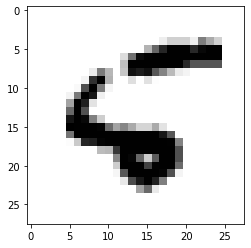

Original Labels: 5
Model prediction: 6


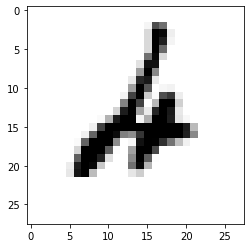

Original Labels: 4
Model prediction: 2


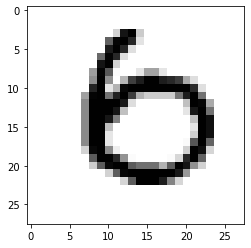

Original Labels: 6
Model prediction: 0


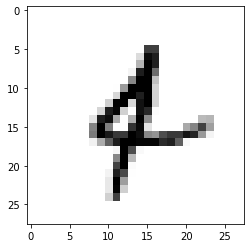

Original Labels: 4
Model prediction: 6


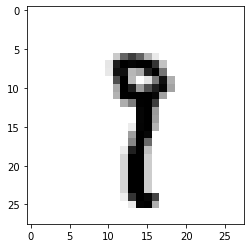

Original Labels: 9
Model prediction: 1


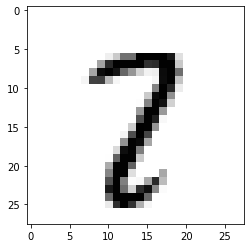

Original Labels: 2
Model prediction: 7


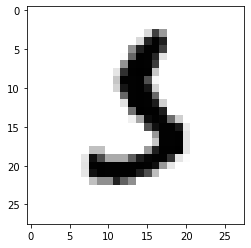

Original Labels: 5
Model prediction: 3


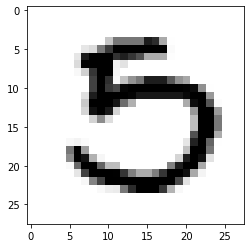

Original Labels: 5
Model prediction: 0


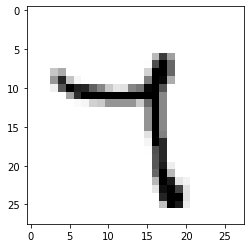

Original Labels: 7
Model prediction: 9


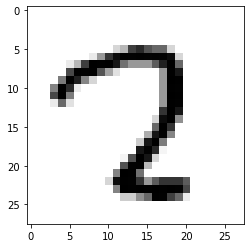

Original Labels: 2
Model prediction: 7


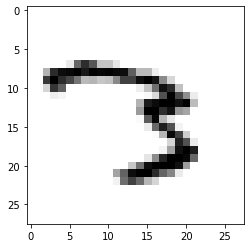

Original Labels: 3
Model prediction: 7


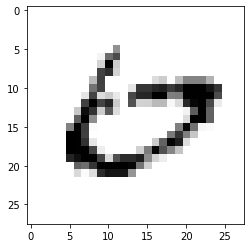

Original Labels: 6
Model prediction: 0


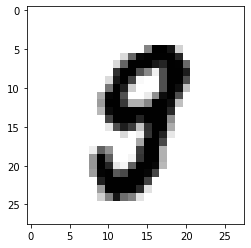

Original Labels: 9
Model prediction: 8


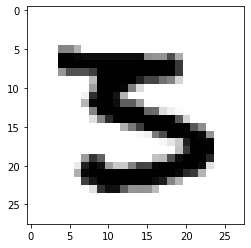

Original Labels: 3
Model prediction: 5


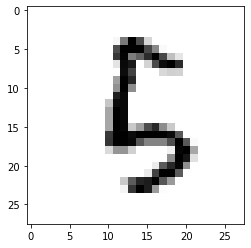

Original Labels: 5
Model prediction: 8


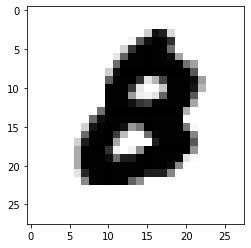

Original Labels: 8
Model prediction: 0


In [24]:
for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)

### <u>Some are hard even for humans. </u>

# Exercise

In the original code developed by sundog education, the accuracy obtained was 93% with one hidden layer of 512 neurons. I added a hidden layer after the input layer with 784 neurons, and let the hidden layer with 512 neurons to connect to the output. My result was 96%